In [ ]:
# 웹 크롤링 + csv 파일 생성

import requests
import pandas as pd
import re
from bs4 import BeautifulSoup
import time
import random

headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36"}

# 읽을 페이지 범위
start_page = 1669
end_page = 0

page_num = start_page

while page_num >= end_page:
    url = f"https://gall.dcinside.com/board/lists/?id=dcbest&list_num=100&sort_type=N&search_head=1&page={page_num}"

    try:
        # 요청
        respons = requests.get(url, headers=headers)
        respons.raise_for_status()  # HTTP 오류가 발생한 경우 예외를 발생시킴
        
        html = respons.text
        soup = BeautifulSoup(html, 'html.parser')
        rows = soup.find_all('tr', attrs={"class": "ub-content us-post thum"})
        print(f"응답완료 {page_num} 추출")
        
    except requests.exceptions.RequestException as e:
        # 요청 실패 시의 페이지 번호와 함께 오류 출력
        print(f"요청 실패: {page_num} 페이지에서 오류 발생")
        print(f"오류 내용: {e}")
        # 요청 실패 후 대기하고 다시 시도
        time.sleep(random.uniform(5, 10))  # 5~10초 대기 후 재시도
        continue  # 예외 발생 시 현재 페이지 번호로 다시 시도

    data = []

    for row in rows:
        columns = row.find_all('td')
        #td 텍스트 추출 후 리스트로 저장
        row_data = [column.get_text(strip=True) for column in columns] 
        # 모든 데이터를 하나의 리스트로 추가 
        data.extend(row_data)  

    # 컬럼 2개를 추가하기 위해 새로운 리스트로 변경
    chunked_data = [data[i:i+6] for i in range(0, len(data), 6)]

    for row in chunked_data:
        # [갤러리] 제목 [댓글수] 형태를 분리하는 정규식
        match = re.match(r"\[(.*?)\](.*?)\[(.*?)\]$", row[1])
        if match:
		        # '갤러리' 부분, 대괄호 제거
            row[1] = match.group(1).strip() 
            # '제목' 부분 
            row.insert(2, match.group(2).strip())  
            # '댓글수' 부분, 대괄호 제거
            row.insert(3, match.group(3).strip())  

    # DataFrame 생성 
    df = pd.DataFrame(chunked_data, columns=["글번호", "갤러리", "제목", "댓글수", "작성자", "작성날짜", "조회수", "추천수"])
    
    # 첫 번째 반복에서만 파일을 새로 생성
    if page_num == start_page:
        df.to_csv('dcinside_data.csv', index=False, encoding='utf-8-sig')
    else:
        # 이후 반복에서는 기존 CSV 파일에 추가
        df.to_csv('dcinside_data.csv', mode='a', header=False, index=False, encoding='utf-8-sig')

    # 1~5초 대기
    time.sleep(random.uniform(1, 5))

    # 다음 페이지로 이동
    page_num -= 1


In [3]:
from wordcloud import WordCloud
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image

# 데이터 읽기
df = pd.read_csv("dcinside_data.csv")
df = df.dropna()
df.shape

(158375, 8)

# 이미지클라우드
## 너무 많이 나오는 단어는 뺌


(2160, 3840, 4)


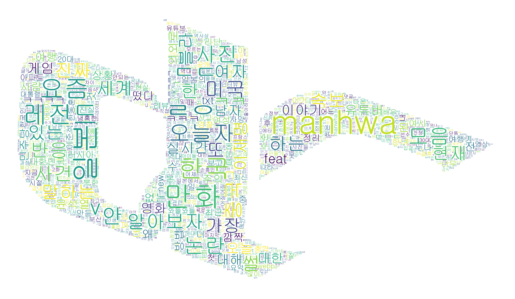

In [ ]:
from wordcloud import WordCloud
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image

# 데이터 읽기
df = pd.read_csv("dcinside_data.csv")
text = ' '.join(df['제목'].dropna().astype(str).apply(lambda x: re.sub(r'(?i)jpg|gif|싱글벙글|후기|훌쩍훌쩍|근황|오싹오싹|스압|이유', '', x)))

# 이미지 불러오기 + 해상도 설정
icon = Image.open('./dcinside.png').resize((3840,2160))    

# 이미지를 RGBA 모드로 변환
icon = icon.convert("RGBA")

# 이미지를 numpy 배열로 변환
icon_data = np.array(icon)

# 흰색 부분을 마스크로 사용 (흰색 부분을 불투명하고, 나머지 부분은 투명하게 설정)
mask_data = np.all(icon_data[:, :, :3] == [255, 255, 255], axis=-1)

# 마스크를 생성: 흰색 부분은 255 (불투명), 나머지 부분은 0 (투명)
icon_data[mask_data] = [0, 0, 0, 255]  # 흰색 부분을 불투명하게 설정
icon_data[~mask_data] = [255, 255, 255, 0]  # 나머지 부분을 투명하게 설정

# 수정된 이미지를 다시 이미지 객체로 변환
mask = Image.fromarray(icon_data)

# PIL 이미지를 numpy 배열로 변환
mask_array = np.array(mask)

# 제목 열을 바로 워드 클라우드에 전달하여 텍스트 생성
wordcloud = WordCloud(font_path="C:\\Windows\\Fonts\\gulim.ttc", 
                      collocations=False,  #자주 등장하는 단어들 제외 false
                      max_words= 2000,
                      max_font_size = 500,
                      background_color='white', 
                       mask = mask_array
                      ).generate(text)

# 워드 클라우드 표시
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


## 무수정 이미지 
## 크기줄임 최대 글자수 줄임 
## jpg와 싱글벙글이 너무 영향력이 큼

(1080, 1980, 4)


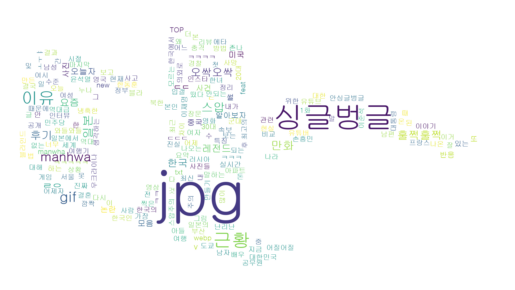

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image

# 데이터 읽기
df = pd.read_csv("dcinside_data.csv")
text = ' '.join(df['제목'].dropna().astype(str))

icon = Image.open('./dcinside.png').resize((1980,1080))    

# 이미지를 RGBA 모드로 변환
icon = icon.convert("RGBA")

# 이미지를 numpy 배열로 변환
icon_data = np.array(icon)

# 흰색 부분을 마스크로 사용 (흰색 부분을 불투명하고, 나머지 부분은 투명하게 설정)
mask_data = np.all(icon_data[:, :, :3] == [255, 255, 255], axis=-1) 

# 마스크를 생성: 흰색 부분은 255 (불투명), 나머지 부분은 0 (투명)
icon_data[mask_data] = [0, 0, 0, 255] 
icon_data[~mask_data] = [255, 255, 255, 0]  

# 수정된 이미지를 다시 이미지 객체로 변환
mask = Image.fromarray(icon_data)

# PIL 이미지를 numpy 배열로 변환 (WordCloud는 NumPy 배열을 필요로 함)
mask_array = np.array(mask)

# 제목 열을 바로 워드클라우드에 전달하여 텍스트 생성
wordcloud = WordCloud(font_path="C:\\Windows\\Fonts\\gulim.ttc", 
                      collocations=False,  #자주 등장하는 단어들 제외 false
                      max_font_size = 1000,
                      min_font_size=10,
                      background_color='white', 
                       mask = mask_array
                      ).generate(text)

# 워드 클라우드 표시
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


(1080, 1980, 4)


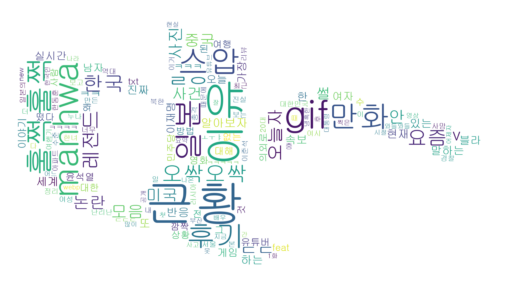

In [ ]:
from wordcloud import WordCloud
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image

# 데이터 읽기
df = pd.read_csv("dcinside_data.csv")
text = ' '.join(df['제목'].dropna().astype(str).apply(lambda x: re.sub(r'(?i)jpg|싱글벙글', '', x)))

icon = Image.open('./dcinside.png').resize((1980,1080))    # 마스크가 될 이미지 불러오기 

# 이미지를 RGBA 모드로 변환 (알파 채널을 추가)
icon = icon.convert("RGBA")

# 이미지를 numpy 배열로 변환
icon_data = np.array(icon)

# 흰색 부분을 마스크로 사용 (흰색 부분을 불투명하고, 나머지 부분은 투명하게 설정)
mask_data = np.all(icon_data[:, :, :3] == [255, 255, 255], axis=-1)  # 흰색 부분 찾기

# 마스크를 생성: 흰색 부분은 255 (불투명), 나머지 부분은 0 (투명)
icon_data[mask_data] = [0, 0, 0, 255]  # 흰색 부분을 불투명하게 설정
icon_data[~mask_data] = [255, 255, 255, 0]  # 나머지 부분을 투명하게 설정

# 수정된 이미지를 다시 이미지 객체로 변환
mask = Image.fromarray(icon_data)

# PIL 이미지를 numpy 배열로 변환 (WordCloud는 NumPy 배열을 필요로 함)
mask_array = np.array(mask)

# 제목 열을 바로 워드 클라우드에 전달하여 텍스트 생성
wordcloud = WordCloud(font_path="C:\\Windows\\Fonts\\gulim.ttc", 
                      collocations=False,  #자주 등장하는 단어들 제외 false
   
                      max_font_size = 1000,
                      min_font_size=20,
                      background_color='white', 
                       mask = mask_array
                      ).generate(text)

# 워드 클라우드 표시
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


# 제목에서 단어 뽑아내기

In [ ]:
import pandas as pd
from konlpy.tag import Okt
from collections import defaultdict

# CSV 파일 읽기
df = pd.read_csv('dcinside_data.csv')

# Okt 객체 생성
okt = Okt()

# 중복 처리 및 명사별 조회수, 추천수 합산을 위한 딕셔너리 초기화
noun_info = defaultdict(lambda: {'count': 0, 'view': 0, 'recommend': 0})

# 제목 열에서 명사 추출 중복처리와 동시에 조회수, 추천수 합산
for _, row in df.iterrows():
    title = str(row['제목'])  # 제목을 문자열로 변환
    views = row['조회수']
    recommends = row['추천수']
    
    # 제목이 NaN이거나 빈 문자열이면 처리하지 않도록 skip
    if title.strip() == '':
        continue
    
    # 제목에서 명사 추출
    nouns = okt.nouns(title)
    
    # 명사별로 중복횟수와 조회수, 추천수 업데이트
    for noun in nouns:
        noun_info[noun]['count'] += 1
        noun_info[noun]['view'] += views
        noun_info[noun]['recommend'] += recommends

# 중복 처리된 명사들로 새로운 데이터프레임 생성
result_data = []
for noun, data in noun_info.items():
    result_data.append([noun, data['count'], data['view'], data['recommend']])

# 새로운 데이터프레임 생성
result_df = pd.DataFrame(result_data, columns=['명사', '중복횟수', '총조회수', '총추천수'])

#정렬
df_sort_by_view_count = result_df.sort_values(by='총조회수', ascending=False)
df_sort_by_word_count = result_df.sort_values(by='중복횟수', ascending=False)

# CSV 파일로 저장
df_sort_by_view_count.to_csv("df_sort_by_view_count.csv")
df_sort_by_word_count.to_csv("df_sort_by_word_count.csv")

# dcinside_data에 긍정도 붙이기

In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# GPU 사용 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 한국어 모델 로드
model_name = "beomi/KcELECTRA-base"  # 예시: 한국어 ELECTRA 모델
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 모델이 GPU에 로드되었는지 확인
print(next(model.parameters()).device)  # 'cuda:0'이 출력되면 GPU에 로드된 것

# CSV 파일 읽기
df = pd.read_csv('dcinside_data.csv')
df = df.dropna()

# 제목 열을 가져와서 배치 처리하는 함수
def batch_analyze_sentiment(titles, batch_size=1024):
    # 텍스트를 배치로 나누어 토큰화
    inputs = tokenizer(titles, padding=True, truncation=True, return_tensors="pt")
    inputs = {key: value.to(device) for key, value in inputs.items()}  # 데이터를 GPU로 이동

    # inputs가 GPU에 있는지 확인
    print(inputs['input_ids'].device)  # 'cuda:0'이어야 GPU에서 실행되고 있음

    with torch.no_grad():  # 불필요한 그래디언트 계산을 피하기 위해
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=-1)  # 예측 결과는 GPU에서 반환됨
    
    return predictions

# 데이터프레임의 '제목' 열을 배치로 나누어 감정 분석 실행
batch_size = 1024 # 배치 크기 조정 (GPU 메모리 여유가 있다면 배치 크기 늘리기)
titles = df['제목'].tolist()

# 배치로 나누어 처리
predictions = []
for i in range(0, len(titles), batch_size):
    batch_titles = titles[i:i+batch_size]
    print(batch_titles)
    batch_predictions = batch_analyze_sentiment(batch_titles)
    
    # GPU에서 직접 처리된 결과를 그대로 사용
    predictions.extend(batch_predictions.tolist())  # 텐서를 리스트로 변환하여 추가

# 결과를 '긍정' 열로 변환 (긍정은 1, 부정은 0)
df['긍정'] = [1 if pred == 1 else 0 for pred in predictions]

# 새로운 CSV 파일로 저장
df.to_csv('dcinside_new_data.csv', index=False)
